In [ ]:
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import load_iris 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
titanic = pd.read_csv('titanic.csv')
iris = load_iris()

Обрабатываем данные

In [ ]:
titanic.head()

,PassengerID,Name,PClass,Age,Sex,Survived,SexCode
0,1,"Allen, Miss Elisabeth Walton",1st,29.00,female,1,1
1,2,"Allison, Miss Helen Loraine",1st,2.00,female,0,1
2,3,"Allison, Mr Hudson Joshua Creighton",1st,30.00,male,0,0
3,4,"Allison, Mrs Hudson JC (Bessie Waldo Daniels)",1st,25.00,female,0,1
4,5,"Allison, Master Hudson Trevor",1st,0.92,male,1,0


In [ ]:
titanic.isnull().sum()

PassengerID      0
Name             0
PClass           0
Age            557
Sex              0
Survived         0
SexCode          0
dtype: int64

In [ ]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerID  1313 non-null   int64  
 1   Name         1313 non-null   object 
 2   PClass       1313 non-null   object 
 3   Age          756 non-null    float64
 4   Sex          1313 non-null   object 
 5   Survived     1313 non-null   int64  
 6   SexCode      1313 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 71.9+ KB


In [ ]:
titanic = titanic.dropna()

In [ ]:
titanic = titanic.drop(columns = ['Name', 'Sex', 'PassengerID'])

In [ ]:
mapping = {'1st': 1,
           '2nd': 2,
           '3rd': 3 }

titanic['PClass'] = titanic['PClass'].map(mapping)
titanic

,PClass,Age,Survived,SexCode
0,1,29.00,1,1
1,1,2.00,0,1
2,1,30.00,0,0
3,1,25.00,0,1
4,1,0.92,1,0
...,...,...,...,...
1308,3,27.00,0,0
1309,3,26.00,0,0
1310,3,22.00,0,0
1311,3,24.00,0,0


In [ ]:
X = titanic.drop(columns = ['Survived'])
Y = titanic['Survived']
X = X.values
Y = Y.values

Создаем нейронную сеть

In [ ]:
INPUT_DIM = 3
OUT_DIM = 2
H_DIM = 5

Точность: 0.6084656084656085


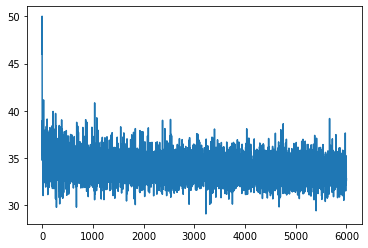

In [ ]:
def relu(t):
    return np.maximum(t, 0)

def softmax(t):
    out = np.exp(t)
    return out / np.sum(out)

def softmax_batch(t):
    out = np.exp(t)
    return out / np.sum(out, axis=1, keepdims=True)

def sparse_cross_entropy(z, y):
    return -np.log(z[0, y])

def sparse_cross_entropy_batch(z, y):
    return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

def to_full_batch(y, num_classes):
    y_full = np.zeros((len(y), num_classes))
    for j, yj in enumerate(y):
        y_full[j, yj] = 1
    return y_full

def relu_deriv(t):
    return (t >= 0).astype(float)

dataset = [(X[i][None, ...], Y[i]) for i in range(len(Y))]

W1 = np.random.rand(INPUT_DIM, H_DIM)
b1 = np.random.rand(1, H_DIM)
W2 = np.random.rand(H_DIM, OUT_DIM)
b2 = np.random.rand(1, OUT_DIM)

W1 = 2 * np.dot((W1 - 0.5), np.sqrt(1/INPUT_DIM))
b1 = 2 * np.dot((b1 - 0.5), np.sqrt(1/INPUT_DIM))
W2 = 2 * np.dot((W2 - 0.5), np.sqrt(1/H_DIM))
b2 = 2 * np.dot((b2 - 0.5), np.sqrt(1/H_DIM))

ALPHA = 0.0002 #шаг 
NUM_EPOCHS = 400 #число эпох
BATCH_SIZE = 50 #количество объектов в одном батче

loss_arr = []

for ep in range(NUM_EPOCHS):
    random.shuffle(dataset)
    for i in range(len(dataset) // BATCH_SIZE):

        batch_x, batch_y = zip(*dataset[i*BATCH_SIZE : i*BATCH_SIZE+BATCH_SIZE])
        x = np.concatenate(batch_x, axis=0)
        y = np.array(batch_y)

        # Прямое распространение
        t1 = np.dot(x, W1) + b1
        h1 = relu(t1)
        t2 = np.dot(h1, W2) + b2
        z = softmax_batch(t2)
        E = np.sum(sparse_cross_entropy_batch(z, y))

        # Обратное распространение
        y_full = to_full_batch(y, OUT_DIM)
        dE_dt2 = z - y_full
        dE_dW2 = np.dot(h1.T,dE_dt2)
        dE_db2 = np.sum(dE_dt2, axis=0, keepdims=True)
        dE_dh1 = np.dot(dE_dt2, W2.T)
        #print(relu_deriv(t1))
        dE_dt1 = dE_dh1 * relu_deriv(t1)#.reshape(10, 5))
        dE_dW1 = np.dot(x.T,dE_dt1)
        dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)

        # Обновление параметров
        W1 = W1 - ALPHA * dE_dW1
        b1 = b1 - ALPHA * dE_db1
        W2 = W2 - ALPHA * dE_dW2
        b2 = b2 - ALPHA * dE_db2

        loss_arr.append(E)

def predict(x): #предсказание для каждого объекта
    t1 = np.dot(x, W1) + b1
    h1 = relu(t1)
    t2 = np.dot(h1, W2) + b2
    z = softmax_batch(t2)
    return z

def calc_accuracy(): #расчёт accuracy для каждого элемента
    correct = 0
    for x, y in dataset:
        z = predict(x)
        y_pred = np.argmax(z)
        if y_pred == y:
            correct += 1
    acc = correct / len(dataset)
    return acc

accuracy = calc_accuracy()
print("Точность:", accuracy)

import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.show()

Точность: 0.98


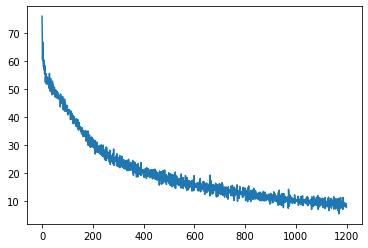

In [ ]:
INPUT_DIM = 4
OUT_DIM = 3
H_DIM = 10

def relu(t):
    return np.maximum(t, 0)

def softmax(t):
    out = np.exp(t)
    return out / np.sum(out)

def softmax_batch(t):
    out = np.exp(t)
    return out / np.sum(out, axis=1, keepdims=True)

def sparse_cross_entropy(z, y):
    return -np.log(z[0, y])

def sparse_cross_entropy_batch(z, y):
    return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

def to_full(y, num_classes):
    y_full = np.zeros((1, num_classes))
    y_full[0, y] = 1
    return y_full

def to_full_batch(y, num_classes):
    y_full = np.zeros((len(y), num_classes))
    for j, yj in enumerate(y):
        y_full[j, yj] = 1
    return y_full

def relu_deriv(t):
    return (t >= 0).astype(float)

iris = datasets.load_iris()
dataset = [(iris.data[i][None, ...], iris.target[i]) for i in range(len(iris.target))]

W1 = np.random.rand(INPUT_DIM, H_DIM)
b1 = np.random.rand(1, H_DIM)
W2 = np.random.rand(H_DIM, OUT_DIM)
b2 = np.random.rand(1, OUT_DIM)

W1 = (W1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
b1 = (b1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
W2 = (W2 - 0.5) * 2 * np.sqrt(1/H_DIM)
b2 = (b2 - 0.5) * 2 * np.sqrt(1/H_DIM)

ALPHA = 0.0002
NUM_EPOCHS = 400
BATCH_SIZE = 50

loss_arr = []

for ep in range(NUM_EPOCHS):
    random.shuffle(dataset)
    for i in range(len(dataset) // BATCH_SIZE):

        batch_x, batch_y = zip(*dataset[i*BATCH_SIZE : i*BATCH_SIZE+BATCH_SIZE])
        x = np.concatenate(batch_x, axis=0)
        y = np.array(batch_y)

        
        t1 = np.dot(x, W1) + b1
        h1 = relu(t1)
        t2 = np.dot(h1, W2) + b2
        z = softmax_batch(t2)
        E = np.sum(sparse_cross_entropy_batch(z, y))

        
        y_full = to_full_batch(y, OUT_DIM)
        dE_dt2 = z - y_full
        dE_dW2 = np.dot(h1.T, dE_dt2)
        dE_db2 = np.sum(dE_dt2, axis=0, keepdims=True)
        dE_dh1 = np.dot(dE_dt2, W2.T)
        dE_dt1 = dE_dh1 * relu_deriv(t1)
        #print(relu_deriv(t1))
        dE_dW1 = np.dot(x.T, dE_dt1)
        dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)

        
        W1 = W1 - ALPHA * dE_dW1
        b1 = b1 - ALPHA * dE_db1
        W2 = W2 - ALPHA * dE_dW2
        b2 = b2 - ALPHA * dE_db2

        loss_arr.append(E)

def predict(x):
    t1 = np.dot(x, W1) + b1
    h1 = relu(t1)
    t2 = np.dot(h1, W2) + b2
    z = softmax_batch(t2)
    return z

def calc_accuracy():
    correct = 0
    for x, y in dataset:
        z = predict(x)
        y_pred = np.argmax(z)
        if y_pred == y:
            correct += 1
    acc = correct / len(dataset)
    return acc

accuracy = calc_accuracy()
print("Точность:", accuracy)

import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.show()

Делаем тоже самое со своим датасетом

In [ ]:
dtf = pd.read_csv('balanced_bank_preprocessed.csv')

In [ ]:
dtf = dtf.drop(['id'], axis = 1)

In [ ]:
dtf.head()

,age,job_cl,marital_cl,education_cl,default_cl,housing_cl,loan_cl,contact_cl,month_cl,day_of_week_cl,...,campaign,pdays,previous,poutcome_cl,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y_cl
0,35,0,1,0,0,0,0,0,2,3,...,1,999,1,1,-1.8,92.893,-46.2,1.266,5099.1,0
1,42,2,0,3,0,1,0,1,2,1,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,1
2,36,0,0,0,0,1,0,0,5,0,...,2,999,0,0,1.4,93.444,-36.1,4.965,5228.1,1
3,37,0,0,1,0,0,1,1,4,2,...,2,999,0,0,1.4,93.918,-42.7,4.963,5228.1,1
4,31,4,1,0,0,0,0,0,1,3,...,1,999,0,0,-1.8,93.075,-47.1,1.365,5099.1,0


In [ ]:
X = dtf.drop(columns = ['y_cl'])
y = dtf['y_cl']
X = X.values
Y = y.values

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
X.shape

(9280, 20)

In [ ]:
Y.shape

(9280,)

Точность: 0.8752155172413794


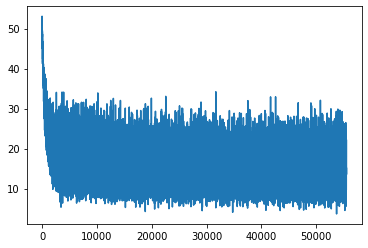

In [ ]:
INPUT_DIM = 20
OUT_DIM = 3
H_DIM = 8

# стохастический градиентный спуск

def relu(t):
    return np.maximum(t, 0)

def softmax(t):
    out = np.exp(t)
    return out / np.sum(out)

def softmax_batch(t):
    out = np.exp(t)
    return out / np.sum(out, axis=1, keepdims=True)

def sparse_cross_entropy(z, y):
    return -np.log(z[0, y]) #идекс правильного класса

def sparse_cross_entropy_batch(z, y):
    return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

def to_full(y, num_classes):
    y_full = np.zeros((1, num_classes))
    y_full[0, y] = 1
    return y_full

def to_full_batch(y, num_classes):
    y_full = np.zeros((len(y), num_classes))
    for j, yj in enumerate(y):
        y_full[j, yj] = 1
    return y_full

def relu_deriv(t):
    return (t >= 0).astype(float)


dataset = [(X[i][None, ...], Y[i]) for i in range(len(Y))]

W1 = np.random.rand(INPUT_DIM, H_DIM)
b1 = np.random.rand(1, H_DIM)
W2 = np.random.rand(H_DIM, OUT_DIM)
b2 = np.random.rand(1, OUT_DIM)

W1 = (W1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
b1 = (b1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
W2 = (W2 - 0.5) * 2 * np.sqrt(1/H_DIM)
b2 = (b2 - 0.5) * 2 * np.sqrt(1/H_DIM)

ALPHA = 0.0001
NUM_EPOCHS = 300 #кол-во эпох
BATCH_SIZE = 50 #по нескольким образцам, чтобы работала лучше и точнее

loss_arr = []

for ep in range(NUM_EPOCHS):
    random.shuffle(dataset) #чтобы показывались всегда в новом порядке
    for i in range(len(dataset) // BATCH_SIZE):

        batch_x, batch_y = zip(*dataset[i*BATCH_SIZE : i*BATCH_SIZE+BATCH_SIZE])
        x = np.concatenate(batch_x, axis=0)
        y = np.array(batch_y)

        #forward (прямое распространение)
        t1 = np.dot(x, W1) + b1
        h1 = relu(t1)
        t2 = np.dot(h1, W2) + b2
        z = softmax_batch(t2) #предсказания модели для матрицы
        E = np.sum(sparse_cross_entropy_batch(z, y))

        #Backward (обратное распространение)
        y_full = to_full_batch(y, OUT_DIM)
        dE_dt2 = z - y_full
        dE_dW2 = np.dot(h1.T, dE_dt2)
        dE_db2 = np.sum(dE_dt2, axis=0, keepdims=True)
        dE_dh1 = np.dot(dE_dt2, W2.T) #.T - транспонированная матрица
        dE_dt1 = dE_dh1 * relu_deriv(t1) # производная
        dE_dW1 = np.dot(x.T, dE_dt1)
        dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)

        # Update (обновление весов)
        #Мещение в строну антиградиента
        W1 = W1 - ALPHA * dE_dW1
        b1 = b1 - ALPHA * dE_db1
        W2 = W2 - ALPHA * dE_dW2
        b2 = b2 - ALPHA * dE_db2

        loss_arr.append(E)

def predict(x): #код прямого распространения
    t1 = np.dot(x, W1) + b1
    h1 = relu(t1)
    t2 = np.dot(h1, W2) + b2
    z = softmax_batch(t2)
    return z #вектор из вероятностей

def calc_accuracy(): #для вычесление точности
    correct = 0
    for x, y in dataset:
        z = predict(x)
        y_pred = np.argmax(z)
        if y_pred == y:
            correct += 1
    acc = correct / len(dataset)
    return acc

accuracy = calc_accuracy()
print("Точность:", accuracy)

import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.show()